In [1]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/stacked_lstm_butter_filter


## Stacked Long-term Short-term memory network (Stacked-LSTM)

Written by Abirlal Metya, Panini Dasgupta, Manmeet Singh (19/12/2019)

import modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.models import Sequential
from keras.layers import Dropout,LSTM,Dense
from keras.layers import LeakyReLU


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import hilbert_data1_jgrjd_20CRV33


Using TensorFlow backend.


In [3]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/stacked_lstm_butter_filter


### Test and Train Splitter:

In [4]:
x_train,_,y_train = hilbert_data1_jgrjd_20CRV33.data_hilbert(datetime.datetime(1979,1,1),datetime.datetime(2008,12,31))
# x_test,_,y_test = hilbert_data1_jgrjd_20CRV33.data_hilbert(datetime.datetime(1974,6,1),datetime.datetime(1978,3,16))
x_test,_,y_test = hilbert_data1_jgrjd_20CRV33.data_hilbert(datetime.datetime(2009,1,1),datetime.datetime(2015,12,31))

In [5]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
y_train.head()

(10839, 48) (10839, 1) (2437, 48) (2437, 1)


,rmm2
date,
1979-04-30,-1.228485
1979-05-01,-1.329972
1979-05-02,-1.365342
1979-05-03,-1.327697
1979-05-04,-1.228673


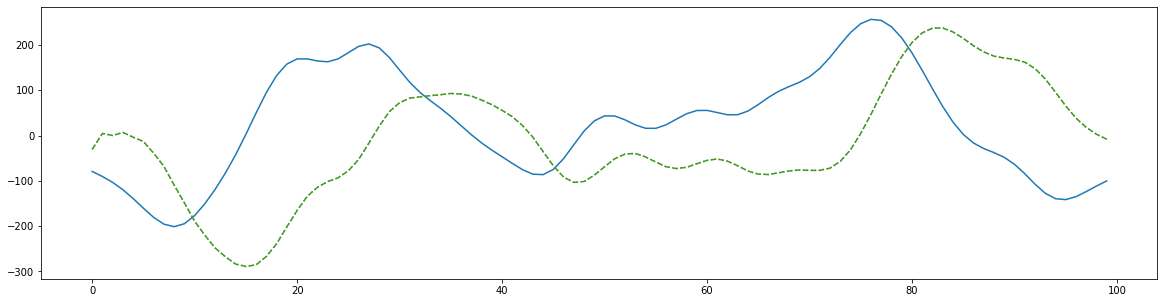

In [6]:
import matplotlib.pyplot as plt#plot the first image in the dataset
from scipy.signal import hilbert
plt.figure(figsize=[20,5])
#plt.imshow(xtrain[1,:,:,0])
plt.plot(np.arange(100),x_train.iloc[0:100,0],'-')
plt.plot(np.arange(100),np.imag(hilbert(x_train.iloc[:,0])[0:100]),':')

plt.plot(np.arange(100),x_train.iloc[0:100,12],'--')

#### Historical pressure

In [7]:
x_test3 = hilbert_data1_jgrjd_20CRV33.data_pres(datetime.datetime(1905,1,1),datetime.datetime(2015,12,31))


/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'RMM2')

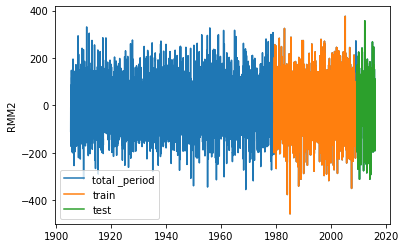

In [8]:
plt.plot(x_test3.iloc[:,0],label = 'total _period')
plt.plot(x_train.iloc[:,0], label = 'train')
plt.plot(x_test.iloc[:,0], label = 'test')
plt.legend()
plt.ylabel('RMM2')

#### scale the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

sc3 = MinMaxScaler()
sc5 = MinMaxScaler()

sc5.fit(x_test3[:])

test_x3 =  sc5.transform(x_test3[:])
train_x = sc5.transform(x_train[:])
test_x  = sc5.transform(x_test[:])


sc3.fit(y_train[:])

train_y = sc3.transform(y_train)

test_y  = sc3.transform(y_test)

train_x.max(),test_x.max(),test_x3.max(),train_y.max(),test_y.max()

(1.0469156527704322,
 1.104979549116266,
 1.0000000000000002,
 0.9999999999999999,
 1.0093241193958034)

In RNN we have to choose a window. Here we choose first 120 points as predictor and next RMM value as predicted. That means RMM will be fitted using previous 120 time steps's pressure of every point

#### split the sequence data for training

In [10]:
def split_sequence(window,x,*args):
    xout  = []
    for i in range(window,len(x)):
        xout.append(x[i-window:i,:])
    
    xout = np.array(xout)
    xout = np.reshape(xout,(xout.shape[0],xout.shape[1],xout.shape[2]))
        
    if np.any(len(args)):
        for y in args:
            yout = []
            for i in range(window,len(y)):
                yout.append(y[i,0])
            yout = np.array(yout)
            yout = yout.reshape(yout.shape[0])
    else:
        yout = [] 
    
    return xout,yout

In [11]:
window = 45
xtrain , ytrain = split_sequence(window,train_x,train_y)
xtest , ytest = split_sequence(window,test_x,test_y)
xtest3,_ = split_sequence(window, test_x3)

#### Cut the data according to batch size

In [12]:
par_b =100

print(x_test3.shape)
te3_lc = ((len(x_test3)-window)//par_b)*par_b

xtest3 = xtest3[:te3_lc,:,:]
print(xtest3.shape)

x_test3.iloc[window:window+te3_lc,:].index
## THis perid data will be available



(40423, 48)
(40300, 45, 48)


DatetimeIndex(['1905-06-14', '1905-06-15', '1905-06-16', '1905-06-17',
               '1905-06-18', '1905-06-19', '1905-06-20', '1905-06-21',
               '1905-06-22', '1905-06-23',
               ...
               '2015-10-05', '2015-10-06', '2015-10-07', '2015-10-08',
               '2015-10-09', '2015-10-10', '2015-10-11', '2015-10-12',
               '2015-10-13', '2015-10-14'],
              dtype='datetime64[ns]', length=40300, freq=None)

In [13]:
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

tr_lc = ((len(x_train)-window)//par_b)*par_b
te_lc =  ((len(x_test)-window)//par_b)*par_b
xtrain = xtrain[:tr_lc,:,:]
ytrain = ytrain[:tr_lc]
xtest = xtest[:te_lc,:,:]
ytest = ytest[:te_lc]

print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(10794, 45, 48) (10794,) (2392, 45, 48) (2392,)
(10700, 45, 48) (10700,) (2300, 45, 48) (2300,)


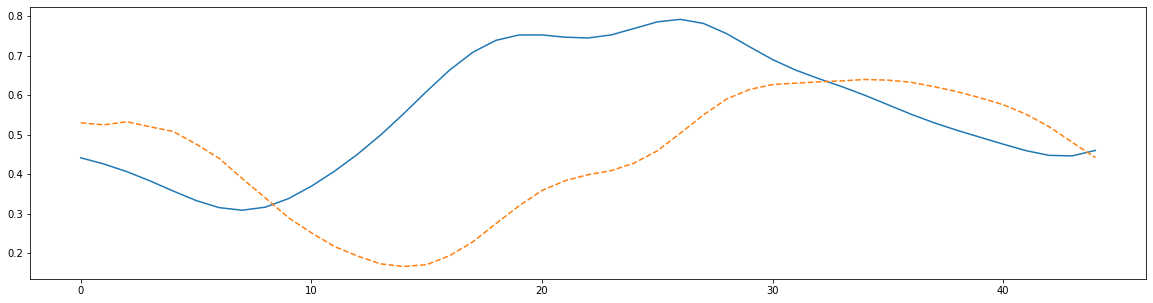

In [14]:
import matplotlib.pyplot as plt#plot the first image in the dataset
from scipy.signal import hilbert
plt.figure(figsize=[20,5])
#plt.imshow(xtrain[1,:,:,0])
plt.plot(xtrain[1,:,0],'-')
#plt.plot(np.imag(hilbert(xtrain[1,:,0])),':')
plt.plot(xtrain[1,:,12],'--')

### Construct the stacked-LSTM model

In [15]:
np.random.seed(7)

In [16]:
batch_size = 50

regressor = Sequential()
regressor.add(LSTM(100, batch_input_shape=(batch_size, xtrain.shape[1], xtrain.shape[2]), stateful=True, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(100, batch_input_shape=(batch_size, xtrain.shape[1], xtrain.shape[2]), stateful=True, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(100, batch_input_shape=(batch_size, xtrain.shape[1], xtrain.shape[2]), stateful=True, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(100, batch_input_shape=(batch_size, xtrain.shape[1], xtrain.shape[2]), stateful=True))
regressor.add(Dropout(0.2))
regressor.add(Dense(1,activation='linear'))
regressor.compile(loss='mae', optimizer='adam')

In [17]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (50, 45, 100)             59600     
_________________________________________________________________
dropout_1 (Dropout)          (50, 45, 100)             0         
_________________________________________________________________
lstm_2 (LSTM)                (50, 45, 100)             80400     
_________________________________________________________________
dropout_2 (Dropout)          (50, 45, 100)             0         
_________________________________________________________________
lstm_3 (LSTM)                (50, 45, 100)             80400     
_________________________________________________________________
dropout_3 (Dropout)          (50, 45, 100)             0         
_________________________________________________________________
lstm_4 (LSTM)                (50, 100)                

In [18]:
history = regressor.fit(xtrain, ytrain,validation_data= (xtest,ytest), epochs=20, batch_size=batch_size, verbose=1, shuffle=False)

Train on 10700 samples, validate on 2300 samples
Epoch 1/20
10700/10700 [==============================] - 26s 2ms/step - loss: 0.1276 - val_loss: 0.0901
Epoch 2/20
10700/10700 [==============================] - 23s 2ms/step - loss: 0.1047 - val_loss: 0.0840
Epoch 3/20
10700/10700 [==============================] - 22s 2ms/step - loss: 0.0887 - val_loss: 0.0824
Epoch 4/20
10700/10700 [==============================] - 23s 2ms/step - loss: 0.0836 - val_loss: 0.0749
Epoch 5/20
10700/10700 [==============================] - 23s 2ms/step - loss: 0.0802 - val_loss: 0.0702
Epoch 6/20
10700/10700 [==============================] - 23s 2ms/step - loss: 0.0784 - val_loss: 0.0698
Epoch 7/20
10700/10700 [==============================] - 23s 2ms/step - loss: 0.0743 - val_loss: 0.0673
Epoch 8/20
10700/10700 [==============================] - 23s 2ms/step - loss: 0.0724 - val_loss: 0.0675
Epoch 9/20
10700/10700 [==============================] - 23s 2ms/step - loss: 0.0720 - val_loss: 0.0663
Epoch 

In [19]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

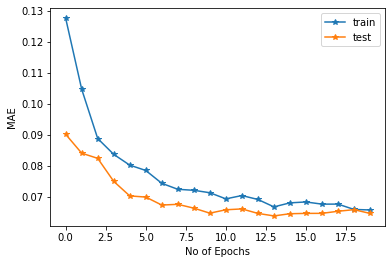

In [20]:
plt.plot(history.history['loss'],'-*',label ='train')
plt.plot(history.history['val_loss'],'-*',label ='test')
plt.ylabel('MAE')
plt.xlabel('No of Epochs')
plt.legend()
# plt.savefig('RMM2_history.png')

regressor.fit(xtrain,ytrain,epochs=30,batch_size=batch_size)

Histogram plot over train and test dataset
To plot histogram real values of the model prediction is required. While model out put is normalized using Min-Max Scalar. So, inverse transform is required before histogrram with ytrain or smooth RMM component

##### Predict train dataset:

training shape = 
(10700, 1)


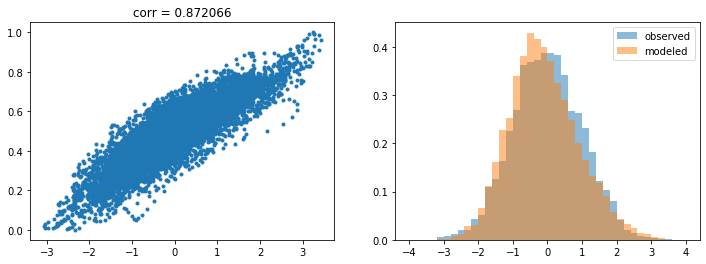

In [21]:
predict1   = regressor.predict(xtrain,batch_size=batch_size)
yy_train   = sc3.inverse_transform(predict1)
yy_train   = yy_train/yy_train.std()
train_corr = np.corrcoef(yy_train[:,0],ytrain)[0,1]

print("training shape = ");print(predict1.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_train[:,0],ytrain,'.')

ax[0].set_title('corr = %f'%train_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_train.rmm2,bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_train,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

##### Predict test dataset:

test shape = 
(2300, 1)


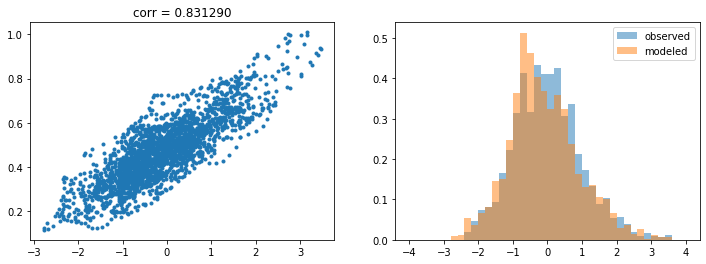

In [22]:
predict2  = regressor.predict(xtest,batch_size=batch_size)
yy_test   = sc3.inverse_transform(predict2)
yy_test   = yy_test/yy_test.std()
test_corr = np.corrcoef(yy_test[:,0],ytest)[0,1]

print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test[:,0],ytest,'.')

ax[0].set_title('corr = %f'%test_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test.rmm2,bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

#### Prediction over long time period (1946-2008)

In [23]:
predict3 = regressor.predict(xtest3,batch_size=batch_size)
predict3 = sc3.inverse_transform(predict3)
predict3 = predict3/np.std(predict3)

Check corelation of observed rmm2 and model prediction over 1979-2008 while using pressure from 1946-2008 

/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Text(0.5, 1.0, 'correlation netween oliver and LSTM = nan')

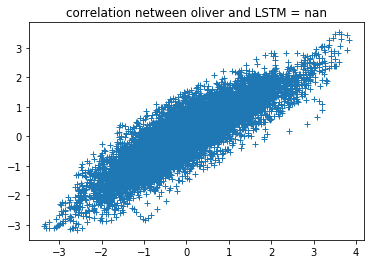

In [24]:
rm = len(xtest3)-len(test_x3)+ window
itx = x_test3[window:rm].index ## We are using 120 days running mean as input so first 120 values should be ignored
#As stacked LSTM is used with batch size of 50, so input and output should have timeseries that divided by 50, so we ignored last 148 values for round off 
rmm2_05_15 = pd.DataFrame(predict3,index = itx)

plt.plot(rmm2_05_15.loc[y_train.index,:],y_train,"+")
corr  = np.corrcoef(rmm2_05_15.loc[y_train.index,:],y_train)[0,1]
plt.title('correlation netween oliver and LSTM = %f'%corr)



In [25]:
itx

DatetimeIndex(['1905-06-14', '1905-06-15', '1905-06-16', '1905-06-17',
               '1905-06-18', '1905-06-19', '1905-06-20', '1905-06-21',
               '1905-06-22', '1905-06-23',
               ...
               '2015-10-05', '2015-10-06', '2015-10-07', '2015-10-08',
               '2015-10-09', '2015-10-10', '2015-10-11', '2015-10-12',
               '2015-10-13', '2015-10-14'],
              dtype='datetime64[ns]', length=40300, freq=None)

Relation with Oliver Index

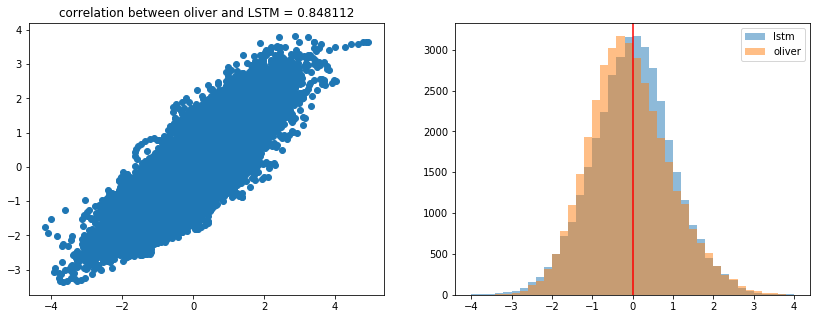

In [26]:
df = pd.read_csv('/home/cccr/supriyo/panini/data/rmm_oliver.csv')
df['date'] = df.year.map(str)+'-'+df.month.map(str)+'-'+df.day.map(str)
df.date = pd.to_datetime(df.date)
df.index = df.date
r1 = df.loc['1906-1-1':'2008-12-31','IHR2'].values
r2 = rmm2_05_15.loc['1906-1-1':'2008-12-31'].values.squeeze()

corr = np.corrcoef(r1,r2)[0,1]

fig,ax = plt.subplots(1,2,figsize = (14,5))
ax[0].scatter(r1,r2)
ax[0].set_title('correlation between oliver and LSTM = %f'%corr)
bins = np.linspace(-4.0,4.0,41)
ax[1].hist(r1,bins,alpha=0.5,label='lstm')
ax[1].hist(r2,bins,alpha = 0.5,label='oliver')
ax[1].axvline(0.0,color='r')
plt.legend()

In [27]:
RMM2         = rmm2_05_15
RMM2.columns = ['rmm2']
# RMM2.to_csv('rmm2_prediction_05-15_minmax_butter_filt.csv')

/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


KeyError: "None of [DatetimeIndex(['2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03',\n               '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07',\n               '2009-05-08', '2009-05-09',\n               ...\n               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',\n               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',\n               '2015-12-30', '2015-12-31'],\n              dtype='datetime64[ns]', name='date', length=2437, freq=None)] are in the [index]"

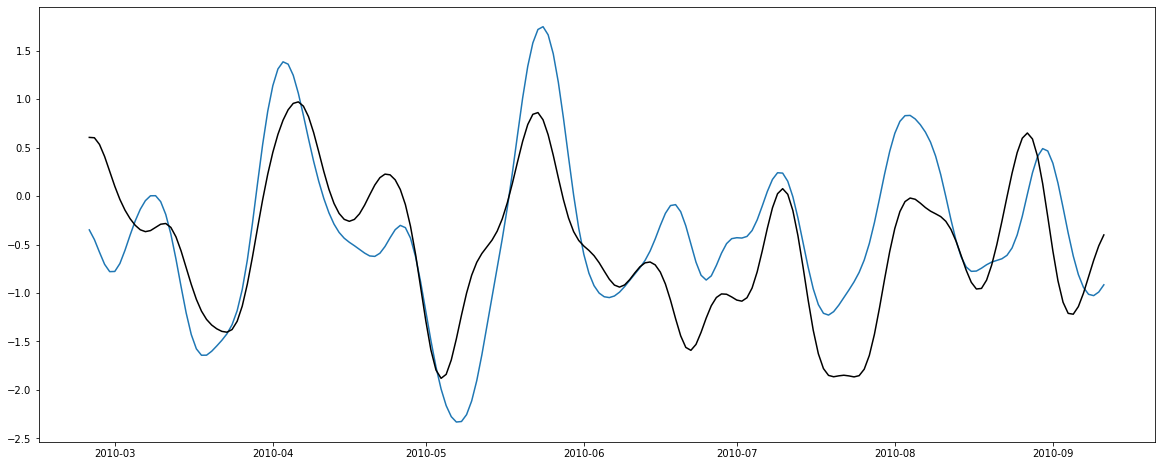

In [28]:
plt.figure(figsize = (20,8))
plt.plot(RMM2.loc[y_test.index][300:500],label = 'predicted LSTM RMM2')
plt.plot(y_test[300:500],'k',label = 'original RMM2')
plt.plot(df.loc[y_test.index,'IHR2'][300:500],label = 'oliver RMM2')
plt.legend()
